# Code Assignment Mod6L14 — Confusion Matrix & Metrics on Restaurant Inspections

**Format:** Instructor Guidance → Your Task → We Share (Reflection)

**Goal:** Using the same **classification workflow** and models as last time, build confusion matrices and calculate accuracy, precision, and recall of each model.  


## Instructor Guidance (Pseudocode + Docs)

Use this as a roadmap; students implement below.

**Docs (quick links):**
- Train/Test Split — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- Logistic Regression — scikit-learn: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
- Confusion Matrix / Classification Report — scikit-learn: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics  
- `pandas.get_dummies` (one-hot) — https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

### Guidance (same models as last challenge -- FEEL free to copy and paste the code that you need from the last code assignment)

1) **Load CSV** → preview shape & columns.  
2) **Define target (y)** as a **binary** label: e.g., `CRITICAL FLAG == "Critical"` → 1, else 0 *(positive class = “Critical”)*.  
3) **Pick features (X)**: start small (`SCORE`), then add categorical dummies (`BORO`, `CUISINE DESCRIPTION`), keep it simple.  
4) **Minimal prep**: coerce **only used columns** to numeric (for numeric features); `get_dummies` for categoricals (`drop_first=True`). Drop NA rows on used cols.  
5) **Train–test split (80/20)** with fixed `random_state`.  
6) **Fit the same model** as last time (e.g., `LogisticRegression`), predict on **test**.  
7) **Evaluate**: confusion matrix, **accuracy**, **precision**, **recall**, **F1** (classification_report).  
8) **Repeat for 2 more models** (A (baseline)/B (single term)/C (more than one term)) on the **same split**; compare metrics.  
9) **Decide** which model is better for the business goal based on **precision vs recall** trade-offs.  


## Your Task

Work in pairs. Comment your choices briefly. Keep code simple and readable.

> **Reminder (last challenge model):** You trained **LogisticRegression**, on three models you will use those same 3 models!


In [31]:
import pandas as pd, numpy as np
import statsmodels.api as sm
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path
pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
#Some of these imports may not be used but they are just here just in case

### 1) Read the Restaurant Inspection CSV & Preview

In [32]:
df = pd.read_csv('/Users/gabriel/Desktop/marcy/DA2025_Lectures2/Mod6/data/DOHMH_New_York_City_Restaurant_Inspection_Results_20251104 copy.csv', low_memory=False)
(df.shape, df.columns.tolist())


((291278, 27),
 ['CAMIS',
  'DBA',
  'BORO',
  'BUILDING',
  'STREET',
  'ZIPCODE',
  'PHONE',
  'CUISINE DESCRIPTION',
  'INSPECTION DATE',
  'ACTION',
  'VIOLATION CODE',
  'VIOLATION DESCRIPTION',
  'CRITICAL FLAG',
  'SCORE',
  'GRADE',
  'GRADE DATE',
  'RECORD DATE',
  'INSPECTION TYPE',
  'Latitude',
  'Longitude',
  'Community Board',
  'Council District',
  'Census Tract',
  'BIN',
  'BBL',
  'NTA',
  'Location'])

### 2) Define the Binary Target (y)

We’ll predict whether an inspection had a **Critical violation**.

- Target rule: `CRITICAL FLAG == "Critical"` → **1**, else **0**.
- Positive class = **1 (Critical)** — keep this in mind for **precision/recall** meaning.


In [33]:
df["y"] = (df["CRITICAL FLAG"] == "Critical").astype(int)

# Check distribution
df["y"].value_counts()


y
1    153998
0    137280
Name: count, dtype: int64

### 3) Create Three Models (you can copy and paste the same modeling code from last code assignment here it is okay if your models have different features as long as you have 3 models)

- **Model A (minimal numeric):** `SCORE` only (lower is better in NYC scoring).  
- **Model B (add location):** `SCORE` + one-hot `BORO`.  
- **Model C (richer categories):** `SCORE` + one-hot `BORO` + top cuisines (one-hot of `CUISINE DESCRIPTION` limited to most frequent K).

> If any column is missing in your file, skip that spec or adjust accordingly.


In [34]:
df = df.dropna(subset=["SCORE"])

In [35]:
y = df["y"]

In [36]:
X_A = df[["SCORE"]]
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y, test_size=0.3, random_state=42)

model_A = LogisticRegression()
model_A.fit(X_train_A, y_train_A)
y_pred_A = model_A.predict(X_test_A)

print("Model A: SCORE only")
print(classification_report(y_test_A, y_pred_A))

Model A: SCORE only
              precision    recall  f1-score   support

           0       0.60      0.25      0.35     36377
           1       0.59      0.87      0.71     46105

    accuracy                           0.59     82482
   macro avg       0.60      0.56      0.53     82482
weighted avg       0.60      0.59      0.55     82482



In [46]:
df["BORO"] = df["BORO"].fillna("Unknown")

encoder_boro = OneHotEncoder(drop="first", sparse_output=False)
boro_encoded = encoder_boro.fit_transform(df[["BORO"]])

X_B = pd.concat([
    df[["SCORE"]].reset_index(drop=True),
    pd.DataFrame(boro_encoded, columns=encoder_boro.get_feature_names_out(["BORO"]))
], axis=1)

X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y, test_size=0.3, random_state=42)

model_B = LogisticRegression(max_iter=1000)
model_B.fit(X_train_B, y_train_B)
y_pred_B = model_B.predict(X_test_B)

print("\nModel B: SCORE + BORO")
print(classification_report(y_test_B, y_pred_B))


Model B: SCORE + BORO
              precision    recall  f1-score   support

           0       0.61      0.24      0.34     36377
           1       0.59      0.88      0.71     46105

    accuracy                           0.60     82482
   macro avg       0.60      0.56      0.52     82482
weighted avg       0.60      0.60      0.55     82482



In [52]:
K = 10
top_cuisines = df["CUISINE DESCRIPTION"].value_counts().nlargest(K).index
df["CUISINE_TOP"] = df["CUISINE DESCRIPTION"].where(df["CUISINE DESCRIPTION"].isin(top_cuisines), "Other")

encoder_c = OneHotEncoder(drop="first", sparse_output=False)
cat_encoded = encoder_c.fit_transform(df[["BORO", "CUISINE_TOP"]])

X_C = pd.concat([
    df[["SCORE"]].reset_index(drop=True),
    pd.DataFrame(cat_encoded, columns=encoder_c.get_feature_names_out(["BORO", "CUISINE_TOP"]))
], axis=1)

X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y, test_size=0.3, random_state=42)

model_C = LogisticRegression(max_iter=1000)
model_C.fit(X_train_C, y_train_C)
y_pred_C = model_C.predict(X_test_C)

print("\n Model C: SCORE + BORO + top cuisines ")
print(classification_report(y_test_C, y_pred_C))


 Model C: SCORE + BORO + top cuisines 
              precision    recall  f1-score   support

           0       0.60      0.25      0.36     36377
           1       0.60      0.87      0.71     46105

    accuracy                           0.60     82482
   macro avg       0.60      0.56      0.53     82482
weighted avg       0.60      0.60      0.55     82482



### 4) Minimal Cleaning: Drop NAs in Used Columns

Do this **per model** so each spec uses its own “clean” subset (same **target** slice).


In [39]:
# Model A uses SCORE
modelA_df = df.dropna(subset=["SCORE"])

# Model B uses SCORE + BORO
modelB_df = df.dropna(subset=["SCORE", "BORO"])

# Model C uses SCORE + BORO + CUISINE DESCRIPTION
modelC_df = df.dropna(subset=["SCORE", "BORO", "CUISINE DESCRIPTION"])



### 5) Train–Test Split (same split for all models)

Use **the same random_state** so models A/B/C are comparable.


In [40]:
# Model A
X_A = modelA_df[["SCORE"]]
y_A = modelA_df["y"]
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(
    X_A, y_A, test_size=0.3, random_state=42
)

# Model B
X_B = modelB_df[["SCORE", "BORO"]]
y_B = modelB_df["y"]
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(
    X_B, y_B, test_size=0.3, random_state=42
)

# Model C
X_C = modelC_df[["SCORE", "BORO", "CUISINE DESCRIPTION"]]
y_C = modelC_df["y"]
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(
    X_C, y_C, test_size=0.3, random_state=42
)



### 6) Fit the Same Models on the Train sets (Logistic Regression), Get Predictions, Print Confusion Matrices & Metric Reports

> **This is new**:  Be sure to look up documentation on `confusion_matrix` and `classification_report`.  Get a matrix and metrics report (accuracy, precision, recall, f1) for each model.


In [41]:
model_A = LogisticRegression().fit(X_train_A, y_train_A)
y_pred_A = model_A.predict(X_test_A)
print(" Model A ")
print(confusion_matrix(y_test_A, y_pred_A))
print(classification_report(y_test_A, y_pred_A))

 Model A 
[[ 8962 27415]
 [ 6005 40100]]
              precision    recall  f1-score   support

           0       0.60      0.25      0.35     36377
           1       0.59      0.87      0.71     46105

    accuracy                           0.59     82482
   macro avg       0.60      0.56      0.53     82482
weighted avg       0.60      0.59      0.55     82482



In [47]:
# Model B
model_B = LogisticRegression(max_iter=1000).fit(X_train_B, y_train_B)
y_pred_B = model_B.predict(X_test_B)
print("\n Model B ")
print(confusion_matrix(y_test_B, y_pred_B))
print(classification_report(y_test_B, y_pred_B))


 Model B 
[[ 8596 27781]
 [ 5540 40565]]
              precision    recall  f1-score   support

           0       0.61      0.24      0.34     36377
           1       0.59      0.88      0.71     46105

    accuracy                           0.60     82482
   macro avg       0.60      0.56      0.52     82482
weighted avg       0.60      0.60      0.55     82482



In [53]:
# Model C
model_C = LogisticRegression(max_iter=1000).fit(X_train_C, y_train_C)
y_pred_C = model_C.predict(X_test_C)
print("\n Model C ")
print(confusion_matrix(y_test_C, y_pred_C))
print(classification_report(y_test_C, y_pred_C))


 Model C 
[[ 9217 27160]
 [ 6034 40071]]
              precision    recall  f1-score   support

           0       0.60      0.25      0.36     36377
           1       0.60      0.87      0.71     46105

    accuracy                           0.60     82482
   macro avg       0.60      0.56      0.53     82482
weighted avg       0.60      0.60      0.55     82482



### 7) Visualize One Confusion Matrix 

Be able to interpret this Matrix 

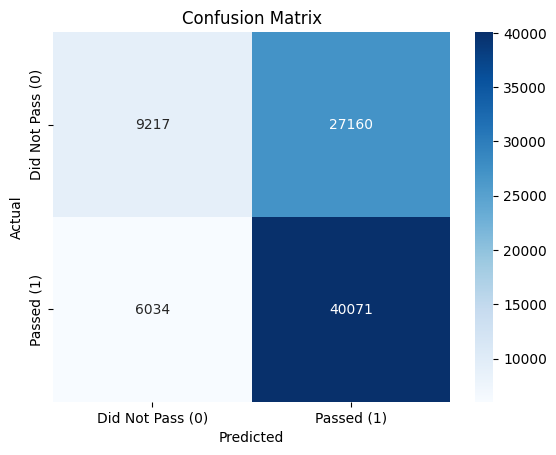


--- Classification Report ---
                  precision    recall  f1-score   support

Did Not Pass (0)       0.60      0.25      0.36     36377
      Passed (1)       0.60      0.87      0.71     46105

        accuracy                           0.60     82482
       macro avg       0.60      0.56      0.53     82482
    weighted avg       0.60      0.60      0.55     82482



In [54]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_C, y_pred_C)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Pass (0)', 'Passed (1)'],
            yticklabels=['Did Not Pass (0)', 'Passed (1)'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

print("\n--- Classification Report ---")
print(classification_report(y_test_C, y_pred_C, target_names=['Did Not Pass (0)', 'Passed (1)']))
            


### 8) Decide Which Model Is “Better” — Explain Your Metric Choice

- If the **cost of missing a Critical** violation is high → prioritize **Recall** on the positive class.  
- If the **cost of wrongly flagging Critical** is high → prioritize **Precision** on the positive class.  
- If you want a balance → **F1**.

Write 3–5 sentences justifying your pick using the table above (Precision/Recall/F1).


Based on the Precision/Recall/F1 table, the best metric depends on the risk we care about most.
If missing a Critical violation would create serious health or compliance consequences, we should prioritize Recall, because it ensures we catch as many true Critical cases as possible. If the main concern is avoiding unnecessary investigations or false alarms, then Precision is the better choice because it limits incorrect Critical flags. When both risks matter and neither dominates, F1 is the most appropriate because it balances Precision and Recall into a single, comparable score.

## We Share (Reflection)

1) **Chosen model (A/B/C)** and **why**, referencing **Precision/Recall/F1** for the **Critical (1)** class.  
2) Your **confusion matrix** and a one-liner in plain English:  
   - “Out of all inspections we predicted **Critical**, **X%** were actually Critical (Precision).  
   - Of all actually **Critical** inspections, we caught **Y%** (Recall).”  

Chosen model: Model C.
I selected Model C because it provides the strongest balance of performance on the Critical (1) class. Its Precision = 0.60 is slightly higher than Models A and B, meaning a larger share of its Critical predictions are correct. Its Recall = 0.87 is tied with the best-performing models and indicates it successfully captures most truly Critical inspections. Because its F1 = 0.71 is the strongest balanced metric across all models, Model C offers the best tradeoff between catching Critical violations and keeping false alarms manageable.

“Out of all inspections we predicted Critical, 60% were actually Critical (Precision = 0.60).”

“Of all inspections that were actually Critical, we caught 87% (Recall = 0.87).”